In [8]:
ls

Deribit_Options_BTC.tsv  Kraken_ethusd.tsv        notebooks/
Deribit_Options_ETH.tsv  Untitled.ipynb
Dockerfile               collector/


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [11]:
df = pd.read_csv('Kraken_ethusd.tsv', sep='\t', names = ['time', 'price', 'volume'], index_col = False)

In [29]:
df['minute'] = df.time.apply(lambda x: x[:16])

In [31]:
df = df.drop(['time', 'month'], axis=1)

In [49]:
d = df.groupby('minute').tail(1)

In [219]:
d.tail()

,price,volume,minute
10404834,239.01,7.750000e+00,2020-03-07 17:58
10404847,239.35,7.000000e-01,2020-03-07 17:59
10404894,238.41,2.200000e-07,2020-03-07 18:00
10404919,238.75,9.519000e+00,2020-03-07 18:01
10404999,238.19,6.680000e+00,2020-03-07 18:02


Надо взять статистику за 20год

In [220]:
s = '2020'
a = d[d['minute'].str.contains(s)]['price'].diff()

# Нормальное распределение

In [92]:
a = df['price'].diff()

In [95]:
a.max(), a.min()

(130.75, -234.68000000000006)

In [227]:
norm_mean, norm_std = a.mean(), a.std()

In [119]:
def std_norm(a):
    m = a.mean()
    d = np.sum((a-m)**2)/(len(a)-1)
    return np.sqrt(d)

In [159]:
def custom_normal(l, mean=0, std=1):
    u1 = np.random.uniform(size=l)
    u2 = np.random.uniform(size=l)
    R_sq = -2 * np.log(u1)
    theta = 2 * np.pi * u2
    z1 = np.sqrt(R_sq) * np.cos(theta)
    return z1*std + mean

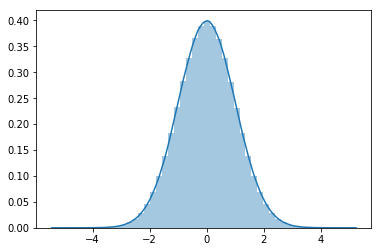

In [160]:
sns.distplot(custom_normal(len(a)))

In [120]:
std_norm(a)

0.5482141315579514

In [104]:
norm_mean, norm_std

(-6.179721881772314e-06, 0.54821413155168)

In [222]:
a = a[1:]
a.shape

(69456,)

применим z стандартизацию наших данных

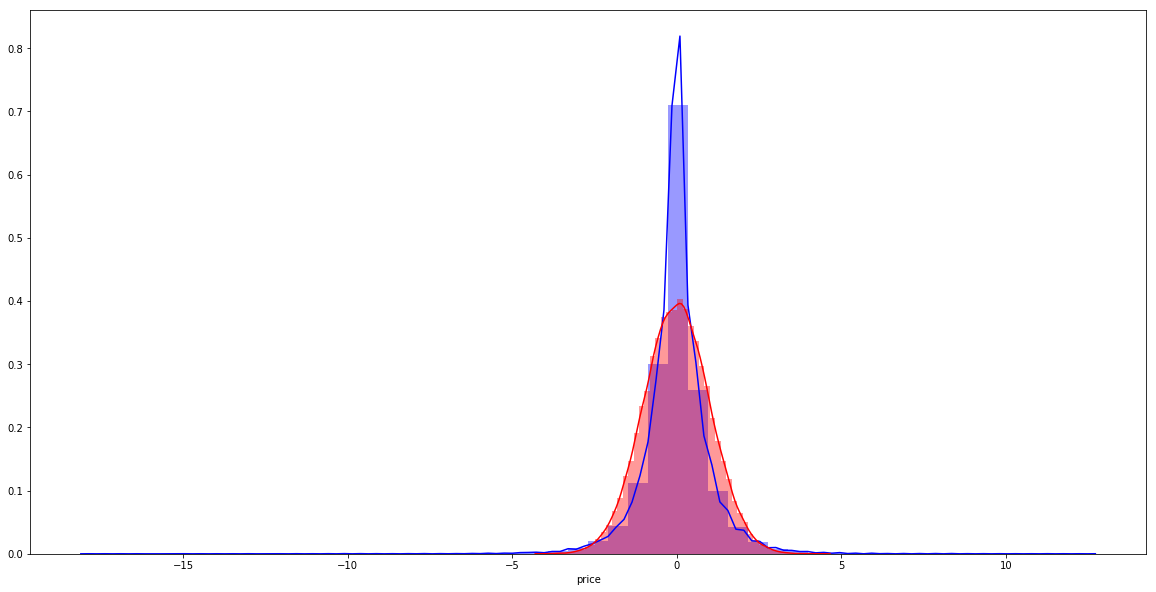

In [228]:
normal = np.random.normal(size=a.shape)
plt.figure(figsize=(20,10))
sns.distplot((a-norm_mean)/norm_std, color='blue')
sns.distplot(normal,  color='red')

у нормального распрелеления 68% наблюдений +- sigma

In [130]:
np.percentile(normal, 16), np.percentile(normal, 84)

(-0.9943304273566551, 0.9951416972641973)

In [132]:
np.percentile((a-norm_mean)/norm_std, 16), np.percentile((a-norm_mean)/norm_std, 84)

(-0.07295291743918068, 0.05473441488452885)

# логнормальное распределение

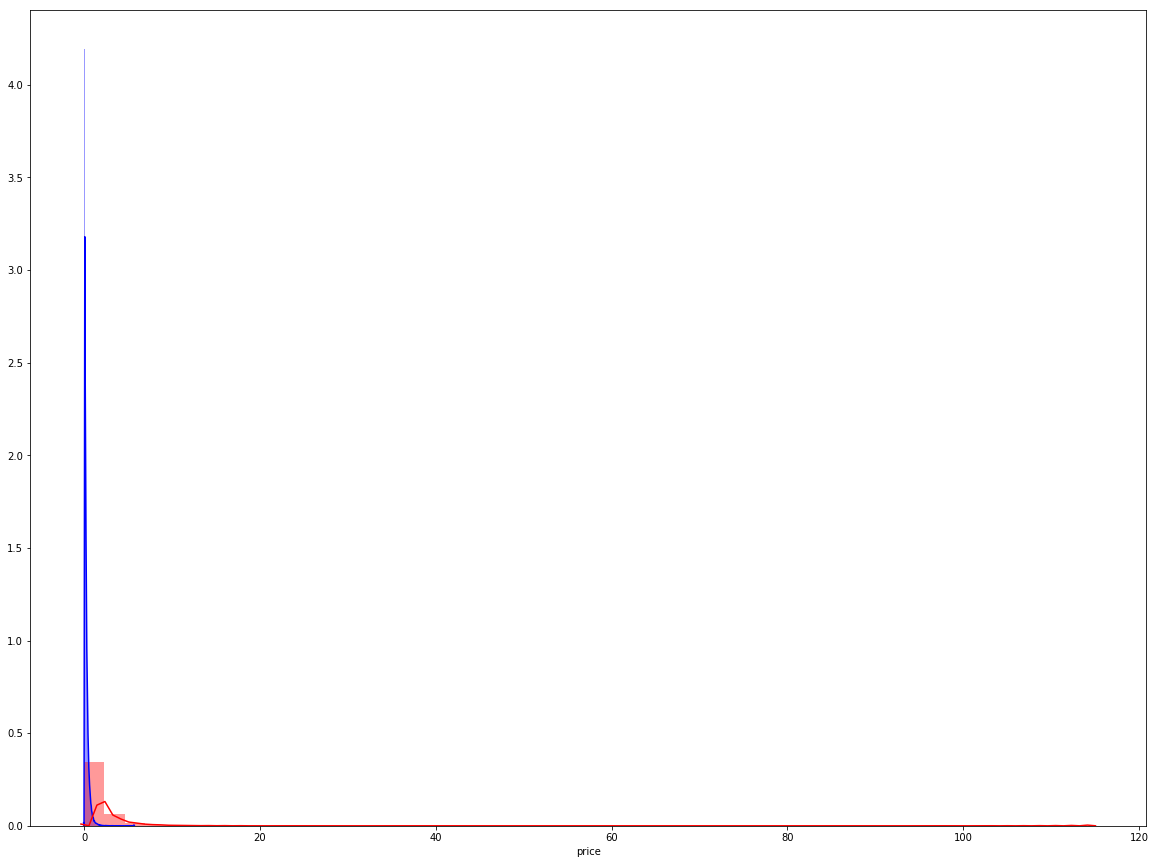

In [226]:
lognormal = np.random.lognormal(size=a.shape)
plt.figure(figsize=(20,15))
sns.distplot(abs(a), color='blue')
sns.distplot(lognormal,  color='red')

In [153]:
np.percentile(lognormal, 16), np.percentile(lognormal, 84)

(0.3696027499667139, 2.70191978600085)

In [168]:
log_mean, log_std

(6.381301575732997e+106, 2.5835248642666387e+107)

используя преобразование бокса мюллера, мы можем получить логнормальное распределние с нужными параметрами

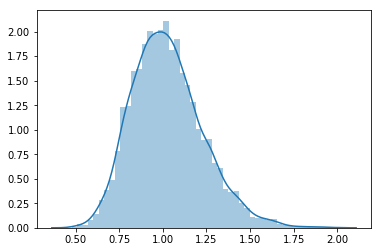

In [216]:
sns.distplot(np.random.lognormal(size=5000, mean=0, sigma=.2))

In [212]:
def mean_convert(m, std):
    return np.exp(m+std/2)
def std_convert(m,std):
    return np.exp(2*m+std)*(np.exp(std)-1)

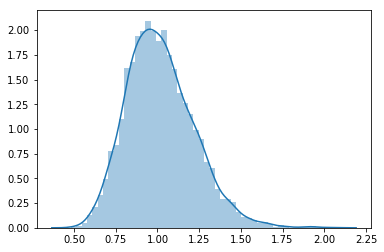

In [217]:
sns.distplot(np.exp(custom_normal(5000, mean=0, std=0.2)))

в общем-то, кажется научился строить нужное лограспределение по заданным параметрам

# Логнормальное распределение от 0 до инф, соответственно можно говорить только о моделировании квадрата(модуля) изменения цены.
немного лучше моделирует логнормальное, но тоже херово

взято из википедии. формула геометрического броуновского движения

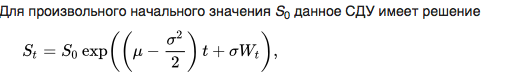

где 

моя мысль такая. Если мы счиатем, что распределение со временем не меняется, то зная распределение за 6 месяцев, мы можем построить распределение за след месяц, уменьшив количество наблюдений в 6 раз. 

In [231]:
a.mean(), a.std()

(0.001576969592259848, 0.31620721713531974)

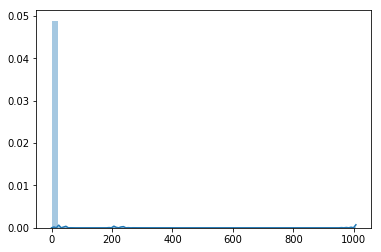

In [237]:
i = np.arange(300)
mu = a.mean()
asigma = a.std()
w = [np.random.normal(loc=0, scale=asigma**2*(j), size=1) for j in i]
s = [np.exp((mu-asigma**2/2)*j+asigma*w[j]) for j in i]
sns.distplot(s)